In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt

from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

/opt/conda/envs/eda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
train_data = pd.read_csv("../dataset/train/train.csv")
test_data = pd.read_csv("../dataset/test/test_data.csv")

# Subject, Object Entities

In [4]:
subject_type = []
object_type = []

for i,j in zip(train_data['subject_entity'], train_data['object_entity']):
    subject_dict, object_dict = eval(i), eval(j)

    subject_type.append(f"[S:{subject_dict['type']}]")
    object_type.append(f"[O:{object_dict['type']}]")

    subject_type.append(f"[/S:{subject_dict['type']}]")
    object_type.append(f"[/O:{object_dict['type']}]")

print(set(subject_type))
print(set(object_type))

{'[S:ORG]', '[/S:ORG]', '[/S:PER]', '[S:PER]'}
{'[O:NOH]', '[O:PER]', '[O:DAT]', '[O:ORG]', '[/O:ORG]', '[O:LOC]', '[/O:POH]', '[/O:DAT]', '[/O:LOC]', '[/O:NOH]', '[O:POH]', '[/O:PER]'}


In [5]:
subject_type = []
object_type = []

for i,j in zip(test_data['subject_entity'], test_data['object_entity']):
    subject_dict, object_dict = eval(i), eval(j)

    subject_type.append(f"[S:{subject_dict['type']}]")
    object_type.append(f"[O:{object_dict['type']}]")

    subject_type.append(f"[/S:{subject_dict['type']}]")
    object_type.append(f"[/O:{object_dict['type']}]")

print(set(subject_type))
print(set(object_type))

{'[S:LOC]', '[/S:LOC]', '[S:PER]', '[S:ORG]', '[/S:ORG]', '[/S:PER]'}
{'[O:NOH]', '[O:DAT]', '[O:PER]', '[O:ORG]', '[/O:POH]', '[/O:ORG]', '[O:LOC]', '[/O:DAT]', '[/O:LOC]', '[/O:NOH]', '[O:POH]', '[/O:PER]'}


# Split train, valid dataset

In [132]:
train_split, valid_split = train_test_split(train_data, test_size=0.1, random_state=0, stratify=train_data[['label']])
train_split.to_csv("./train_split_v1.csv")
valid_split.to_csv("./valid_split_v1.csv")
print('num of train_split', len(train_split))
print('num of test_split', len(valid_split))

num of train_split 29223
num of test_split 3247


In [134]:
train_split['label'].value_counts()


label
no_relation                            8581
org:top_members/employees              3856
per:employee_of                        3216
per:title                              1893
org:member_of                          1679
org:alternate_names                    1188
per:origin                             1111
org:place_of_headquarters              1075
per:date_of_birth                      1017
per:alternate_names                     901
per:spouse                              716
per:colleagues                          481
per:parents                             468
org:founded                             405
org:members                             378
per:date_of_death                       376
org:product                             342
per:children                            274
per:place_of_residence                  174
per:other_family                        171
per:place_of_birth                      149
org:founded_by                          139
per:product               

In [130]:
valid_split['label'].value_counts()

label
no_relation                            953
org:top_members/employees              428
per:employee_of                        357
per:title                              210
org:member_of                          187
org:alternate_names                    132
per:origin                             123
org:place_of_headquarters              120
per:date_of_birth                      113
per:alternate_names                    100
per:spouse                              79
per:colleagues                          53
per:parents                             52
org:founded                             45
per:date_of_death                       42
org:members                             42
org:product                             38
per:children                            30
per:place_of_residence                  19
per:other_family                        19
per:place_of_birth                      17
org:founded_by                          16
per:product                             14
per:s

# Utility Functions

In [57]:
def set_difference(df_a, df_b):
    outer_join = pd.merge(df_a, df_b, how='outer', indicator=True)
    diff_set = outer_join.query('_merge=="left_only"').drop(columns='_merge')
    
    return diff_set

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    
    return percentile_

def get_columns(data, index, columns):
    target = data[data['id']==index]

    return target[columns]

model = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')


# 0. EDA Summary

### Train Data

In [107]:
# colums => (sentence / subject / object / label)
print("[TRAIN DATA]")
print("total num of data =", len(train_data))
print("unique sentences Í∞úÏàò =", train_data['sentence'].nunique())
print("label Í∞úÏàò =", train_data['label'].nunique())

print("sentenceÍ∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò =", \
      sum(train_data.duplicated(keep=False, subset=['sentence'])))

print("ssolÏù¥ ÏôÑÏ†ÑÌûà ÏùºÏπòÌïòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò (ex) 1 1 3 3 4 Ïù¥Î©¥ 1, 3 ÎëêÍ∞úÎ°ú Ïπ¥Ïö¥Ìä∏) =", \
      sum(train_data.duplicated(subset=['sentence', 'subject_entity', 'object_entity', 'label']))) # Ï†úÍ±∞Ìï¥ÎèÑ Î¨¥Î∞©

print("ssoÍ∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò, (ex_ 1 1 3 Ïù¥Î©¥ 1 1 ÎëêÍ∞úÎ°ú Ïπ¥Ïö¥Ìä∏) =", \
      sum(train_data.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])))


sub_sso_ssol = set_difference(train_data[train_data.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])],\
                              train_data[train_data.duplicated(subset=['sentence', 'subject_entity', 'object_entity', 'label'])])
dup_sso_sub_sso_ssol = sub_sso_ssol[sub_sso_ssol.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])]
print("ssoÍ∞Ä ÏùºÏπòÌïòÎäîÎç∞ labelÏù¥ Îã§Î•∏ Îç∞Ïù¥ÌÑ∞ Ïàò =", sum(sub_sso_ssol.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])))# Ïñ¥Îäê labelÏù¥ Ï†ïÎãµÏù∏ÏßÄ ÌåêÎã®ÌïòÍ∏∞ Ïñ¥Î†µÎã§, Í∑∏ÎÉ• ÎëîÎã§

print("word level Î¨∏Ïû• Í∏∏Ïù¥(95 percentile) =",\
      train_data['sentence'].apply(lambda x: len(x.split(' '))).agg([percentile(0.95)]).values[0])

print("token level Î¨∏Ïû• Í∏∏Ïù¥(95 percentile) =",\
      train_data['sentence'].apply(lambda x: len(tokenizer(x)['input_ids'])).agg([percentile(0.95)]).values[0])


[TRAIN DATA]
total num of data = 32470
unique sentences Í∞úÏàò = 28803
label Í∞úÏàò = 30
sentenceÍ∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò = 7090
ssolÏù¥ ÏôÑÏ†ÑÌûà ÏùºÏπòÌïòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò (ex) 1 1 3 3 4 Ïù¥Î©¥ 1, 3 ÎëêÍ∞úÎ°ú Ïπ¥Ïö¥Ìä∏) = 42
ssoÍ∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò, (ex_ 1 1 3 Ïù¥Î©¥ 1 1 ÎëêÍ∞úÎ°ú Ïπ¥Ïö¥Ìä∏) = 93
ssoÍ∞Ä ÏùºÏπòÌïòÎäîÎç∞ labelÏù¥ Îã§Î•∏ Îç∞Ïù¥ÌÑ∞ Ïàò = 10
word level Î¨∏Ïû• Í∏∏Ïù¥(95 percentile) = 41.0
token level Î¨∏Ïû• Í∏∏Ïù¥(95 percentile) = 101.0


### Test Data

In [109]:
# colums => (sentence / subject / object / label)
print("[TEST DATA]")
print("total num of data =", len(test_data))
print("unique sentences Í∞úÏàò =", test_data['sentence'].nunique())
print("label Í∞úÏàò =", test_data['label'].nunique())

print("sentenceÍ∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò =", \
      sum(test_data.duplicated(keep=False, subset=['sentence'])))

print("ssoÍ∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò, (ex_ 1 1 3 Ïù¥Î©¥ 1 1 ÎëêÍ∞úÎ°ú Ïπ¥Ïö¥Ìä∏) =", \
      sum(test_data.duplicated(keep=False, subset=['sentence', 'subject_entity', 'object_entity'])))

print("word level Î¨∏Ïû• Í∏∏Ïù¥(95 percentile) =",\
      test_data['sentence'].apply(lambda x: len(x.split(' '))).agg([percentile(0.95)]).values[0])

print("token level Î¨∏Ïû• Í∏∏Ïù¥(95 percentile) =",\
      test_data['sentence'].apply(lambda x: len(tokenizer(x)['input_ids'])).agg([percentile(0.95)]).values[0])


[TEST DATA]
total num of data = 7765
unique sentences Í∞úÏàò = 7764
label Í∞úÏàò = 1
sentenceÍ∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò = 2
ssoÍ∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞ Ïàò, (ex_ 1 1 3 Ïù¥Î©¥ 1 1 ÎëêÍ∞úÎ°ú Ïπ¥Ïö¥Ìä∏) = 0
word level Î¨∏Ïû• Í∏∏Ïù¥(95 percentile) = 39.0
token level Î¨∏Ïû• Í∏∏Ïù¥(95 percentile) = 93.0


# 1. Train/Test dataset overview

In [4]:
train_data.head()

id                                           sentence  \
0   0  „ÄàSomething„ÄâÎäî Ï°∞ÏßÄ Ìï¥Î¶¨Ïä®Ïù¥ Ïì∞Í≥† ÎπÑÌãÄÏ¶àÍ∞Ä 1969ÎÖÑ Ïï®Î≤î „ÄäAbbey R...   
1   1  Ìò∏ÎÇ®Ïù¥ Í∏∞Î∞òÏù∏ Î∞îÎ•∏ÎØ∏ÎûòÎãπ¬∑ÎåÄÏïàÏã†Îãπ¬∑ÎØºÏ£ºÌèâÌôîÎãπÏù¥ Ïö∞Ïó¨Í≥°Ï†à ÎÅùÏóê Ìï©ÎãπÌï¥ ÎØºÏÉùÎãπ(Í∞ÄÏπ≠)Ïúº...   
2   2  KÎ¶¨Í∑∏2ÏóêÏÑú ÏÑ±Ï†Å 1ÏúÑÎ•º Îã¨Î¶¨Í≥† ÏûàÎäî Í¥ëÏ£ºFCÎäî ÏßÄÎÇú 26Ïùº ÌïúÍµ≠ÌîÑÎ°úÏ∂ïÍµ¨Ïó∞ÎßπÏúºÎ°úÎ∂ÄÌÑ∞...   
3   3  Í∑†ÏùºÍ∞Ä ÏÉùÌôúÏö©ÌíàÏ†ê (Ï£º)ÏïÑÏÑ±Îã§Ïù¥ÏÜå(ÎåÄÌëú Î∞ïÏ†ïÎ∂Ä)Îäî ÏΩîÎ°úÎÇò19 Î∞îÏù¥Îü¨Ïä§Î°ú Ïñ¥Î†§ÏõÄÏùÑ Í≤™...   
4   4  1967ÎÖÑ ÌîÑÎ°ú ÏïºÍµ¨ ÎìúÎûòÌîÑÌä∏ 1ÏàúÏúÑÎ°ú ÏöîÎØ∏Ïö∞Î¶¨ ÏûêÏù¥Ïñ∏Ï∏†ÏóêÍ≤å ÏûÖÎã®ÌïòÎ©¥ÏÑú Îì±Î≤àÌò∏Îäî 8...   

                                      subject_entity  \
0  {'word': 'ÎπÑÌãÄÏ¶à', 'start_idx': 24, 'end_idx': 26...   
1  {'word': 'ÎØºÏ£ºÌèâÌôîÎãπ', 'start_idx': 19, 'end_idx': ...   
2  {'word': 'Í¥ëÏ£ºFC', 'start_idx': 21, 'end_idx': 2...   
3  {'word': 'ÏïÑÏÑ±Îã§Ïù¥ÏÜå', 'start_idx': 13, 'end_idx': ...   
4  {'word': 'ÏöîÎØ∏Ïö∞Î¶¨ ÏûêÏù¥Ïñ∏Ï∏†', 'start_idx': 22, 'end_id...   

                                       object_entity  \
0  {'word': 'Ï°∞ÏßÄ Ìï¥Î¶¨Ïä®', 'start_idx': 13, 'end_idx':...   
1  {'word': 'ÎåÄÏïàÏã†Îãπ', 'start_idx': 14, 'end_idx': 1...   
2  {'word': 'ÌïúÍµ≠ÌîÑÎ°úÏ∂ïÍµ¨Ïó∞Îßπ', 'start_idx': 34, 'end_idx...   
3  {'word': 'Î∞ïÏ†ïÎ∂Ä', 'start_idx': 22, 'end_idx': 24...   
4  {'word': '1967', 'start_idx': 0, 'end_idx': 3,...   

                       label     source  
0                no_relation  wikipedia  
1                no_relation   wikitree  
2              org:member_of   wikitree  
3  org:top_members/employees   wikitree  
4                no_relation  wikipedia

In [5]:
test_data.head()

id                                           sentence  \
0   0               ÏßÄÎÇú 15Ïùº MBC 'ÌÉêÏÇ¨Í∏∞Ìöç Ïä§Ìä∏Î†àÏù¥Ìä∏'Í∞Ä Ïù¥ ÏÇ¨Ïã§ÏùÑ Î≥¥ÎèÑÌñàÎã§.   
1   1  ÏÇ¨ÎûëÏä§Îü¨Ïö¥ ‚ÄòÌîÑÎ¶∞ÏÑ∏Ïä§ ÌîÑÎßÅ‚ÄôÏùò Ïù¥Î¶ÑÏùÄ Î¥ÑÏùò Í≥µÏ£ºÎãò: Princess(s)PringÏù¥...   
2   2  ÌïúÌé∏, Î≥∏Ïù∏(Ïù¥Í∑ºÏïà)ÏùÑ Î™®Îç∏Î°ú Ìïú MBC ÌäπÏßëÎìúÎùºÎßà Í∞Ä 1995ÎÖÑ 6.25 ÌäπÏßëÍ∑πÏúº...   
3   3  Ï†ïÏ∞ΩÏÜêÏùÄ ÍπÄÏßàÍ≥º Í∞ôÏù¥ ÎåÄÍ∂êÎ°ú Îã¨Î†§Í∞Ä Í≥†Î≥ÄÌïòÎ©∞ 'Ïã†ÏùÄ Ïã§Î°ú Î™®Î•¥Í≥† ÍπÄÏßàÎßå ÌòºÏûê Ï∞∏Ïó¨Ìïò...   
4   4  ÎãπÏãú ÎØºÏ£ºÎãπ Ïù¥ÏßÑÎ†® ÏãúÏùòÏõêÏùÄ Í∂åÏòÅÏßÑ ÏãúÏû•ÏóêÍ≤å "Í∏¥Í∏â ÏÉùÍ≥ÑÏûêÍ∏àÏùÑ Ïôú ÌòÑÍ∏àÏúºÎ°ú ÏßÄÏõêÌïòÏßÄ...   

                                      subject_entity  \
0  {'word': 'MBC', 'start_idx': 7, 'end_idx': 9, ...   
1  {'word': 'ÌîÑÎ¶∞ÏÑ∏Ïä§ ÌîÑÎßÅ', 'start_idx': 7, 'end_idx':...   
2  {'word': 'Í≤ΩÏ∞∞', 'start_idx': 121, 'end_idx': 12...   
3  {'word': 'ÏÑ∏Ï°∞', 'start_idx': 78, 'end_idx': 79,...   
4  {'word': 'ÎØºÏ£ºÎãπ', 'start_idx': 3, 'end_idx': 5, ...   

                                       object_entity  label     source  
0  {'word': 'ÌÉêÏÇ¨Í∏∞Ìöç Ïä§Ìä∏Î†àÏù¥Ìä∏', 'start_idx': 12, 'end_i...    100   wikitree  
1  {'word': 'Í≥µÏ£º', 'start_idx': 84, 'end_idx': 85,...    100  wikipedia  
2  {'word': '1995ÎÖÑ', 'start_idx': 31, 'end_idx': ...    100  wikipedia  
3  {'word': 'Ï†ïÏ∞ΩÏÜê', 'start_idx': 0, 'end_idx': 2, ...    100  wikipedia  
4  {'word': 'Í∂åÏòÅÏßÑ', 'start_idx': 16, 'end_idx': 18...    100   wikitree

In [12]:
print(f"ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: {len(train_data)}")
print(f"ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: {len(test_data)}")

ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: 32470
ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞ Í∞úÏàò: 7765


### Í≤∞Ï∏°Ïπò Ïó¨Î∂Ä ÌôïÏù∏

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32470 entries, 0 to 32469
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              32470 non-null  int64 
 1   sentence        32470 non-null  object
 2   subject_entity  32470 non-null  object
 3   object_entity   32470 non-null  object
 4   label           32470 non-null  object
 5   source          32470 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.5+ MB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7765 entries, 0 to 7764
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7765 non-null   int64 
 1   sentence        7765 non-null   object
 2   subject_entity  7765 non-null   object
 3   object_entity   7765 non-null   object
 4   label           7765 non-null   int64 
 5   source          7765 non-null   object
dtypes: int64(2), object(4)
memory usage: 364.1+ KB


# 2. label Î≥Ñ Î∂ÑÌè¨ 

micro F1 score -> no_relation ÏùÑ Ï†úÏô∏Ìïú ÏÉòÌîåÏù¥ Í∞ÄÏû• ÎßéÏùÄ ÌÅ¥ÎûòÏä§Ïóê Í∞ÄÏû• ÎßéÏùÄ Í∞ÄÏ§ëÏπòÎ•º Î∂ÄÏó¨ÌïúÎã§.

In [15]:
# label Ïùò Í∞úÏàò
print(f"ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò label Í∞úÏàò: {len(train_data['label'].unique())}")
print(f"ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞Ïùò label (100ÏúºÎ°ú ÏûÑÏùò ÌëúÌòÑÎêòÏñ¥ Í∞ÄÎ†§Ï†∏ÏûàÎã§.) : {len(test_data['label'].unique())}")

ÌïôÏäµ Îç∞Ïù¥ÌÑ∞Ïùò label Í∞úÏàò: 30
ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞Ïùò label (100ÏúºÎ°ú ÏûÑÏùò ÌëúÌòÑÎêòÏñ¥ Í∞ÄÎ†§Ï†∏ÏûàÎã§.) : 1


In [16]:
train_data['label'].value_counts()

label
no_relation                            9534
org:top_members/employees              4284
per:employee_of                        3573
per:title                              2103
org:member_of                          1866
org:alternate_names                    1320
per:origin                             1234
org:place_of_headquarters              1195
per:date_of_birth                      1130
per:alternate_names                    1001
per:spouse                              795
per:colleagues                          534
per:parents                             520
org:founded                             450
org:members                             420
per:date_of_death                       418
org:product                             380
per:children                            304
per:place_of_residence                  193
per:other_family                        190
per:place_of_birth                      166
org:founded_by                          155
per:product               

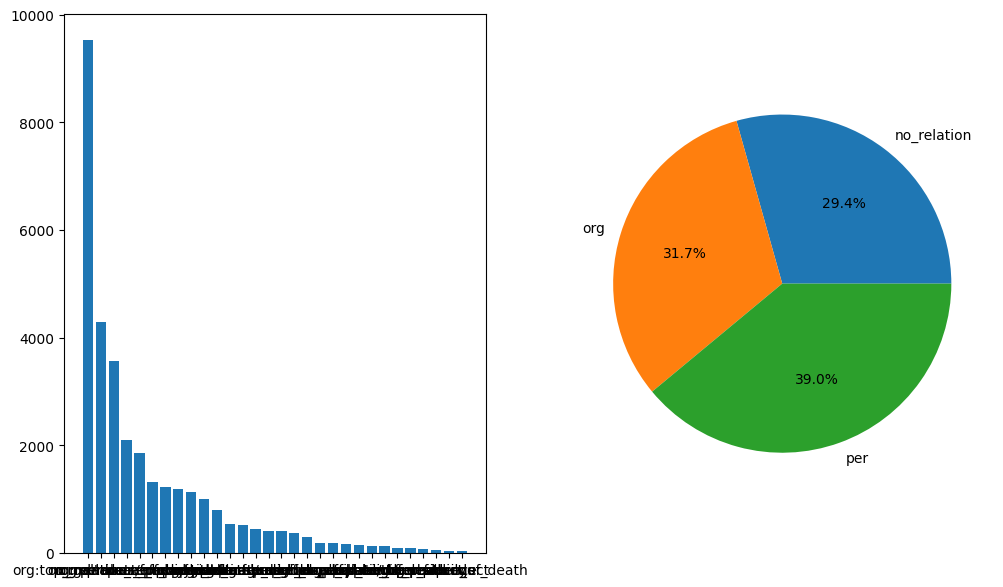

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].bar(train_data['label'].unique(), train_data['label'].value_counts())

labels = {'no_relation': 0, 'org': 0, 'per': 0}
for label in train_data['label']:
  if label != 'no_relation':
    labels[label[:3]] += 1
  else:
    labels[label] += 1

axes[1].pie([num/32470 for num in labels.values()],labels=labels.keys(), autopct='%.1f%%')

plt.show()

# 3. source Î≥Ñ Î∂ÑÌè¨ 

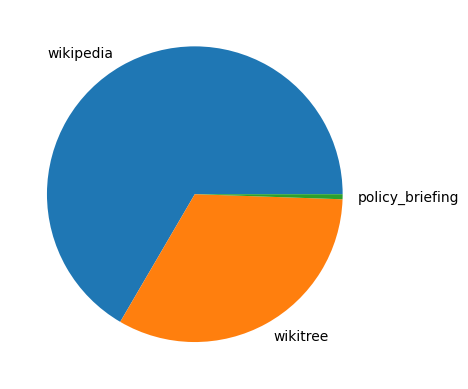

In [5]:
plt.pie(train_data['source'].value_counts(),labels=train_data['source'].unique())
plt.show()

# 4. Sentence Length

### Ïñ¥Ï†à Îã®ÏúÑ Î¨∏Ïû• Í∏∏Ïù¥ Î∂ÑÏÑù, word level sentence length

In [24]:
train_data['len'] = train_data['sentence'].apply(lambda x: len(x.split(' ')))
test_data['len'] = test_data['sentence'].apply(lambda x: len(x.split(' ')))

print('Train Data\n', train_data.agg({'len':['min', 'max', 'mean']}))
print()
print('Test Data\n', test_data.agg({'len':['min', 'max', 'mean']}))

Train Data
              len
min     3.000000
max   108.000000
mean   20.641423

Test Data
             len
min    3.000000
max   99.000000
mean  20.455892


len
(10, 20]     0.473018
(20, 30]     0.265355
(0, 10]      0.118462
(30, 40]     0.092712
(40, 50]     0.031571
(50, 60]     0.011397
(60, 70]     0.004435
(70, 80]     0.001786
(80, 90]     0.000986
(90, 100]    0.000277
Name: proportion, dtype: float64


<Axes: xlabel='len'>

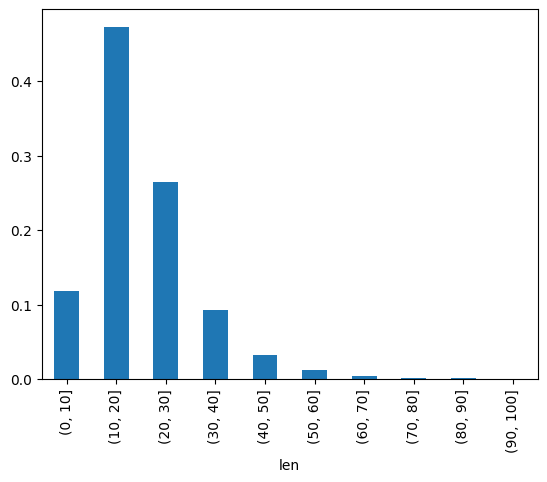

In [27]:
bins = list(range(0, 108, 10))
sentence_len_categories = pd.cut(train_data["len"], bins)
print(sentence_len_categories.value_counts(normalize=True))
sentence_len_categories.value_counts(normalize=True).sort_index().plot(kind="bar")

len
(10, 20]    0.463035
(20, 30]    0.275374
(0, 10]     0.120428
(30, 40]    0.101494
(40, 50]    0.027821
(50, 60]    0.008372
(60, 70]    0.002705
(70, 80]    0.000386
(80, 90]    0.000386
Name: proportion, dtype: float64


<Axes: xlabel='len'>

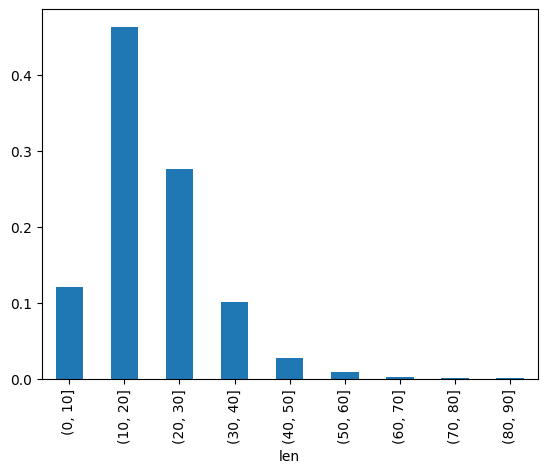

In [28]:
bins = list(range(0, 99, 10))
sentence_len_categories = pd.cut(test_data["len"], bins)
print(sentence_len_categories.value_counts(normalize=True))
sentence_len_categories.value_counts(normalize=True).sort_index().plot(kind="bar")

### ÌÜ†ÌÅ∞ Îã®ÏúÑ Î¨∏Ïû• Í∏∏Ïù¥ Î∂ÑÏÑù, Token level sentence length

In [30]:
model = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

In [31]:
train_data['token_len'] = train_data['sentence'].apply(lambda x: len(tokenizer(x)['input_ids']))
test_data['token_len'] = test_data['sentence'].apply(lambda x: len(tokenizer(x)['input_ids']))

In [32]:
print(train_data.agg({'token_len':['min', 'max', 'mean']}))
print(test_data.agg({'token_len':['min', 'max', 'mean']}))

       token_len
min     9.000000
max   231.000000
mean   52.958608
      token_len
min        12.0
max       223.0
mean       51.2


token_len
(40, 60]      0.358179
(20, 40]      0.331752
(60, 80]      0.171867
(80, 100]     0.067854
(100, 120]    0.028306
(0, 20]       0.020020
(120, 140]    0.012782
(140, 160]    0.004712
(160, 180]    0.002649
(180, 200]    0.001109
(200, 220]    0.000770
Name: proportion, dtype: float64


<Axes: xlabel='token_len'>

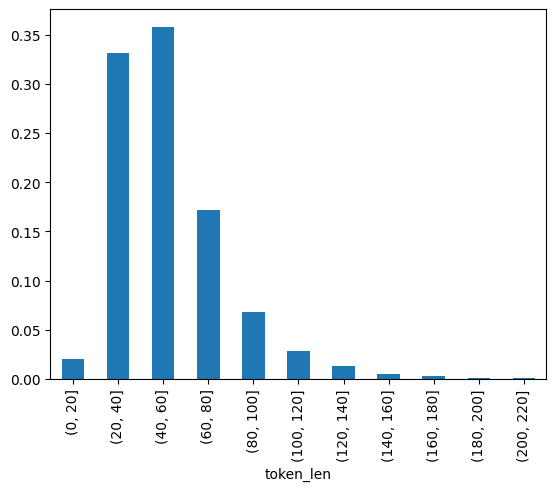

In [33]:
bins = list(range(0, 231, 20))
sentence_len_categories = pd.cut(train_data["token_len"], bins)
print(sentence_len_categories.value_counts(normalize=True))
sentence_len_categories.value_counts(normalize=True).sort_index().plot(kind="bar")

token_len
(20, 40]      0.347244
(40, 60]      0.339001
(60, 80]      0.179933
(80, 100]     0.067620
(0, 20]       0.030010
(100, 120]    0.023828
(120, 140]    0.007470
(140, 160]    0.003478
(180, 200]    0.000773
(160, 180]    0.000644
(200, 220]    0.000000
Name: proportion, dtype: float64


<Axes: xlabel='token_len'>

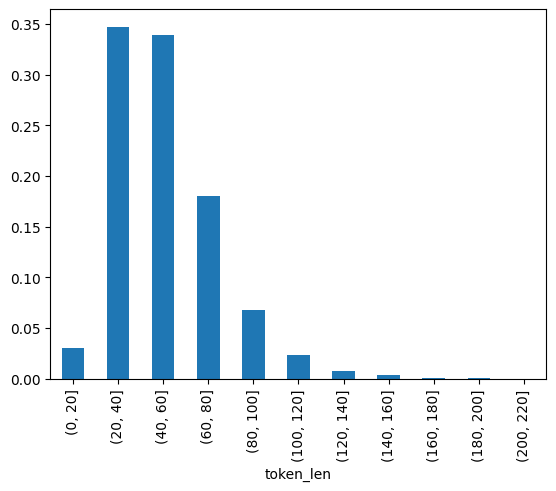

In [34]:
bins = list(range(0, 223, 20))
sentence_len_categories = pd.cut(test_data["token_len"], bins)
print(sentence_len_categories.value_counts(normalize=True))
sentence_len_categories.value_counts(normalize=True).sort_index().plot(kind="bar")

# 5. Ï§ëÎ≥µ sentence

### Ï¥ù 32470Í∞úÏùò Îç∞Ïù¥ÌÑ∞Ï§ëÏóê sentence Ï§ëÎ≥µÏùÑ Ï†úÏô∏ÌïòÎ©¥ 28803Í∞úÏùò Î¨∏Ïû•Ïù¥ ÏûàÎã§.
ÎèôÏùºÌïú sentenceÎ•º Í∞ÄÏßÄÍ≥† ÏÑúÎ°ú Îã§Î•∏ label ÌòπÏùÄ entityÎ•º Ï†ÅÏö©ÌïòÍ≥† ÏûàÏùåÏùÑ ÎÇòÌÉÄÎÇ∏Îã§.

In [35]:
train_data.nunique()

id                32470
sentence          28803
subject_entity    26340
object_entity     25704
label                30
source                3
len                  95
token_len           207
dtype: int64

In [36]:
test_data.nunique()

id                7765
sentence          7764
subject_entity    6758
object_entity     7162
label                1
source               3
len                 73
token_len          153
dtype: int64

In [51]:
def duplicated(data, subset, keep=False):
    return data.duplicated(keep=keep, subset=subset)

In [52]:
print(f'sentence Í∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞Ïùò Ïàò: {sum(duplicated(train_data, ["sentence"]))}')
print(f'sentence, subject_entity ÏôÄ object_entity Í∞Ä ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞Ïùò Ïàò: {sum(duplicated(train_data,["sentence", "subject_entity", "object_entity"]))}')
print(f'sentence, subject-entity, object_entity ÏôÄ label Ïù¥ ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞Ïùò Ïàò: {sum(duplicated(train_data, ["sentence","subject_entity","object_entity", "label"]))}')

sentence Í∞Ä Ï§ëÎ≥µÎêòÎäî Îç∞Ïù¥ÌÑ∞Ïùò Ïàò: 7090
sentence, subject_entity ÏôÄ object_entity Í∞Ä ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞Ïùò Ïàò: 93
sentence, subject-entity, object_entity ÏôÄ label Ïù¥ ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞Ïùò Ïàò: 84


In [53]:
sso = train_data[duplicated(train_data,["sentence", "subject_entity", "object_entity"])]
ssol = sso_indcies = train_data[duplicated(train_data,["sentence", "subject_entity", "object_entity", "label"])]

### Train Data : [sentence, subject_entity, object_entity, label] ÍπåÏßÄ ÏôÑÎ≤ΩÌûà ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞

In [54]:
ssol.sort_values('sentence')

id                                           sentence  \
22090  22090  1959-60 ÏãúÏ¶å Ïù¥ÌõÑÏùò ÏïåÌåå ÏóêÌä∏ÎãàÌÇ§ / ÏàòÌéòÎ•¥Î¶¨Í∞Ä ÏóòÎùºÎã§, Í∑∏Î¶¨Ïä§ Ïªµ, Í∑∏Î¶¨Í≥†...   
9618    9618  1959-60 ÏãúÏ¶å Ïù¥ÌõÑÏùò ÏïåÌåå ÏóêÌä∏ÎãàÌÇ§ / ÏàòÌéòÎ•¥Î¶¨Í∞Ä ÏóòÎùºÎã§, Í∑∏Î¶¨Ïä§ Ïªµ, Í∑∏Î¶¨Í≥†...   
25368  25368  2001ÎÖÑ 4Ïõî ÎØºÏ£ºÍµ≠ÎØºÎãπ ÍπÄÏú§Ìôò ÏùòÏõêÍ≥º ÎØºÏ£ºÎãπ ÏùòÏõê ÏÇ¨Ïù¥Ïùò Ï†ïÏ±Ö Ïó∞Ìï©Í≥º Í¥ÄÎ†®Ìïú ÌÜµ...   
2500    2500  2001ÎÖÑ 4Ïõî ÎØºÏ£ºÍµ≠ÎØºÎãπ ÍπÄÏú§Ìôò ÏùòÏõêÍ≥º ÎØºÏ£ºÎãπ ÏùòÏõê ÏÇ¨Ïù¥Ïùò Ï†ïÏ±Ö Ïó∞Ìï©Í≥º Í¥ÄÎ†®Ìïú ÌÜµ...   
3547    3547  2010ÎÖÑ 10Ïõî 15Ïùº Ï†ÑÎùºÎ∂ÅÎèÑÏ≤≠ÏùÑ Î∞©Î¨∏Ìïú ÎßπÌòïÍ∑ú ÌñâÏ†ïÏïàÏ†ÑÎ∂Ä Ïû•Í¥ÄÏùÄ ÎèÑÎÇ¥ ÏßÄÏûêÏ≤¥Í∞Ñ...   
...      ...                                                ...   
27325  27325    ÌéÄÏπòÎÑ¨Î°úÎäî 10cmÏùò Í∂åÏ†ïÏó¥Ïù¥ ÌîºÏ≤òÎßÅÏúºÎ°ú Ï∞∏Ïó¨Ìïú 'ÎØ∏ÏïàÌï¥ÏÑú ÎØ∏ÏïàÌï¥'Î°ú Î¨¥ÎåÄÏóê Ïò¨ÎûêÎã§.   
14658  14658                              Ìï®Ïó∞ÏßÄÎäî Ìï®ÏòÅÏ§Ä Ïò§ÎöúÍ∏∞ ÌöåÏû•Ïùò Ïû•ÎÖÄÎã§.   
6936    6936                              Ìï®Ïó∞ÏßÄÎäî Ìï®ÏòÅÏ§Ä Ïò§ÎöúÍ∏∞ ÌöåÏû•Ïùò Ïû•ÎÖÄÎã§.   
20898  20898  ÌôîÎ†§Ìïú Ïû¨Í∏∞Î•º Îí§Î°úÌïòÍ≥† Í≥†(ÊïÖ) ÏïàÏû¨ÌôòÏóêÍ≤å ÎèàÏùÑ ÎπåÎ†§Ï§¨Îã§Îäî Î£®Î®∏Î°ú ÎßàÏùåÍ≥†ÏÉùÏùÑ ÌïòÎçò ...   
4248    4248  ÌôîÎ†§Ìïú Ïû¨Í∏∞Î•º Îí§Î°úÌïòÍ≥† Í≥†(ÊïÖ) ÏïàÏû¨ÌôòÏóêÍ≤å ÎèàÏùÑ ÎπåÎ†§Ï§¨Îã§Îäî Î£®Î®∏Î°ú ÎßàÏùåÍ≥†ÏÉùÏùÑ ÌïòÎçò ...   

                                          subject_entity  \
22090  {'word': 'ÏàòÌéòÎ•¥Î¶¨Í∞Ä ÏóòÎùºÎã§', 'start_idx': 25, 'end_id...   
9618   {'word': 'ÏàòÌéòÎ•¥Î¶¨Í∞Ä ÏóòÎùºÎã§', 'start_idx': 25, 'end_id...   
25368  {'word': 'ÎØºÏ£ºÍµ≠ÎØºÎãπ', 'start_idx': 9, 'end_idx': 1...   
2500   {'word': 'ÎØºÏ£ºÍµ≠ÎØºÎãπ', 'start_idx': 9, 'end_idx': 1...   
3547   {'word': 'Ï†ÑÎùºÎ∂ÅÎèÑÏ≤≠', 'start_idx': 14, 'end_idx': ...   
...                                                  ...   
27325  {'word': 'Í∂åÏ†ïÏó¥', 'start_idx': 12, 'end_idx': 14...   
14658  {'word': 'Ïò§ÎöúÍ∏∞', 'start_idx': 9, 'end_idx': 11,...   
6936   {'word': 'Ïò§ÎöúÍ∏∞', 'start_idx': 9, 'end_idx': 11,...   
20898  {'word': 'ÏµúÏßÑÏã§', 'start_idx': 46, 'end_idx': 48...   
4248   {'word': 'ÏµúÏßÑÏã§', 'start_idx': 46, 'end_idx': 48...   

                                           object_entity  \
22090  {'word': 'Í∑∏Î¶¨Ïä§', 'start_idx': 36, 'end_idx': 38...   
9618   {'word': 'Í∑∏Î¶¨Ïä§', 'start_idx': 36, 'end_idx': 38...   
25368  {'word': 'ÎØºÏ£ºÎãπ', 'start_idx': 23, 'end_idx': 25...   
2500   {'word': 'ÎØºÏ£ºÎãπ', 'start_idx': 23, 'end_idx': 25...   
3547   {'word': 'ÌñâÏ†ïÏïàÏ†ÑÎ∂Ä', 'start_idx': 29, 'end_idx': ...   
...                                                  ...   
27325  {'word': '10cm', 'start_idx': 6, 'end_idx': 9,...   
14658  {'word': 'Ìï®ÏòÅÏ§Ä', 'start_idx': 5, 'end_idx': 7, ...   
6936   {'word': 'Ìï®ÏòÅÏ§Ä', 'start_idx': 5, 'end_idx': 7, ...   
20898  {'word': '2008ÎÖÑ 10Ïõî 2Ïùº', 'start_idx': 51, 'end...   
4248   {'word': '2008ÎÖÑ 10Ïõî 2Ïùº', 'start_idx': 51, 'end...   

                           label     source  len  
22090                no_relation  wikipedia   14  
9618                 no_relation  wikipedia   14  
25368                no_relation  wikipedia   14  
2500                 no_relation  wikipedia   14  
3547                 no_relation  wikipedia   54  
...                          ...        ...  ...  
27325            per:employee_of   wikitree    9  
14658  org:top_members/employees   wikitree    5  
6936   org:top_members/employees   wikitree    5  
20898          per:date_of_death   wikitree   21  
4248           per:date_of_death   wikitree   21  

[84 rows x 7 columns]

### Train Data : [sentence, subject_entity, object_entity] ÍπåÏßÄ ÏôÑÎ≤ΩÌûà ÎèôÏùºÌïú Îç∞Ïù¥ÌÑ∞

In [55]:
sso.sort_values('sentence')

id                                           sentence  \
9618    9618  1959-60 ÏãúÏ¶å Ïù¥ÌõÑÏùò ÏïåÌåå ÏóêÌä∏ÎãàÌÇ§ / ÏàòÌéòÎ•¥Î¶¨Í∞Ä ÏóòÎùºÎã§, Í∑∏Î¶¨Ïä§ Ïªµ, Í∑∏Î¶¨Í≥†...   
22090  22090  1959-60 ÏãúÏ¶å Ïù¥ÌõÑÏùò ÏïåÌåå ÏóêÌä∏ÎãàÌÇ§ / ÏàòÌéòÎ•¥Î¶¨Í∞Ä ÏóòÎùºÎã§, Í∑∏Î¶¨Ïä§ Ïªµ, Í∑∏Î¶¨Í≥†...   
25368  25368  2001ÎÖÑ 4Ïõî ÎØºÏ£ºÍµ≠ÎØºÎãπ ÍπÄÏú§Ìôò ÏùòÏõêÍ≥º ÎØºÏ£ºÎãπ ÏùòÏõê ÏÇ¨Ïù¥Ïùò Ï†ïÏ±Ö Ïó∞Ìï©Í≥º Í¥ÄÎ†®Ìïú ÌÜµ...   
2500    2500  2001ÎÖÑ 4Ïõî ÎØºÏ£ºÍµ≠ÎØºÎãπ ÍπÄÏú§Ìôò ÏùòÏõêÍ≥º ÎØºÏ£ºÎãπ ÏùòÏõê ÏÇ¨Ïù¥Ïùò Ï†ïÏ±Ö Ïó∞Ìï©Í≥º Í¥ÄÎ†®Ìïú ÌÜµ...   
255      255  2010ÎÖÑ 10Ïõî 15Ïùº Ï†ÑÎùºÎ∂ÅÎèÑÏ≤≠ÏùÑ Î∞©Î¨∏Ìïú ÎßπÌòïÍ∑ú ÌñâÏ†ïÏïàÏ†ÑÎ∂Ä Ïû•Í¥ÄÏùÄ ÎèÑÎÇ¥ ÏßÄÏûêÏ≤¥Í∞Ñ...   
...      ...                                                ...   
4212    4212  ÌïúÌé∏ Ï†ÑÎùºÎÇ®ÎèÑÎäî ÏµúÍ∑º ÌôïÏßÑÏûêÍ∞Ä Î∞úÏÉùÌïú ÏàúÏ≤úÏãúÏôÄ Ïó¨ÏàòÏãúÏóê ÎßàÏä§ÌÅ¨Î•º Í∞ÅÍ∞Å 2ÎßåÏû•Ïî© Ï¥ù ...   
6936    6936                              Ìï®Ïó∞ÏßÄÎäî Ìï®ÏòÅÏ§Ä Ïò§ÎöúÍ∏∞ ÌöåÏû•Ïùò Ïû•ÎÖÄÎã§.   
14658  14658                              Ìï®Ïó∞ÏßÄÎäî Ìï®ÏòÅÏ§Ä Ïò§ÎöúÍ∏∞ ÌöåÏû•Ïùò Ïû•ÎÖÄÎã§.   
4248    4248  ÌôîÎ†§Ìïú Ïû¨Í∏∞Î•º Îí§Î°úÌïòÍ≥† Í≥†(ÊïÖ) ÏïàÏû¨ÌôòÏóêÍ≤å ÎèàÏùÑ ÎπåÎ†§Ï§¨Îã§Îäî Î£®Î®∏Î°ú ÎßàÏùåÍ≥†ÏÉùÏùÑ ÌïòÎçò ...   
20898  20898  ÌôîÎ†§Ìïú Ïû¨Í∏∞Î•º Îí§Î°úÌïòÍ≥† Í≥†(ÊïÖ) ÏïàÏû¨ÌôòÏóêÍ≤å ÎèàÏùÑ ÎπåÎ†§Ï§¨Îã§Îäî Î£®Î®∏Î°ú ÎßàÏùåÍ≥†ÏÉùÏùÑ ÌïòÎçò ...   

                                          subject_entity  \
9618   {'word': 'ÏàòÌéòÎ•¥Î¶¨Í∞Ä ÏóòÎùºÎã§', 'start_idx': 25, 'end_id...   
22090  {'word': 'ÏàòÌéòÎ•¥Î¶¨Í∞Ä ÏóòÎùºÎã§', 'start_idx': 25, 'end_id...   
25368  {'word': 'ÎØºÏ£ºÍµ≠ÎØºÎãπ', 'start_idx': 9, 'end_idx': 1...   
2500   {'word': 'ÎØºÏ£ºÍµ≠ÎØºÎãπ', 'start_idx': 9, 'end_idx': 1...   
255    {'word': 'Ï†ÑÎùºÎ∂ÅÎèÑÏ≤≠', 'start_idx': 14, 'end_idx': ...   
...                                                  ...   
4212   {'word': 'Ï†ÑÎùºÎÇ®ÎèÑ', 'start_idx': 3, 'end_idx': 6,...   
6936   {'word': 'Ïò§ÎöúÍ∏∞', 'start_idx': 9, 'end_idx': 11,...   
14658  {'word': 'Ïò§ÎöúÍ∏∞', 'start_idx': 9, 'end_idx': 11,...   
4248   {'word': 'ÏµúÏßÑÏã§', 'start_idx': 46, 'end_idx': 48...   
20898  {'word': 'ÏµúÏßÑÏã§', 'start_idx': 46, 'end_idx': 48...   

                                           object_entity  \
9618   {'word': 'Í∑∏Î¶¨Ïä§', 'start_idx': 36, 'end_idx': 38...   
22090  {'word': 'Í∑∏Î¶¨Ïä§', 'start_idx': 36, 'end_idx': 38...   
25368  {'word': 'ÎØºÏ£ºÎãπ', 'start_idx': 23, 'end_idx': 25...   
2500   {'word': 'ÎØºÏ£ºÎãπ', 'start_idx': 23, 'end_idx': 25...   
255    {'word': 'ÌñâÏ†ïÏïàÏ†ÑÎ∂Ä', 'start_idx': 29, 'end_idx': ...   
...                                                  ...   
4212   {'word': 'Ïó¨ÏàòÏãú', 'start_idx': 26, 'end_idx': 28...   
6936   {'word': 'Ìï®ÏòÅÏ§Ä', 'start_idx': 5, 'end_idx': 7, ...   
14658  {'word': 'Ìï®ÏòÅÏ§Ä', 'start_idx': 5, 'end_idx': 7, ...   
4248   {'word': '2008ÎÖÑ 10Ïõî 2Ïùº', 'start_idx': 51, 'end...   
20898  {'word': '2008ÎÖÑ 10Ïõî 2Ïùº', 'start_idx': 51, 'end...   

                           label     source  len  
9618                 no_relation  wikipedia   14  
22090                no_relation  wikipedia   14  
25368                no_relation  wikipedia   14  
2500                 no_relation  wikipedia   14  
255                  no_relation  wikipedia   54  
...                          ...        ...  ...  
4212                 org:members   wikitree   23  
6936   org:top_members/employees   wikitree    5  
14658  org:top_members/employees   wikitree    5  
4248           per:date_of_death   wikitree   21  
20898          per:date_of_death   wikitree   21  

[93 rows x 7 columns]

### sso, ssolÏùò Ï∞®ÏßëÌï© Íµ¨ÌïòÍ∏∞ (ÎèôÏùºÌïú sentence, sub/obj entityÏóêÏÑú labelÏù¥ Îã§Î•∏ Í≤ΩÏö∞)

In [56]:
# sso ÏôÄ ssol Ïùò Ï∞®ÏßëÌï© Íµ¨ÌïòÍ∏∞
df = pd.merge(sso, ssol, how='outer', indicator=True)
df.query('_merge=="left_only"').drop(columns='_merge').sort_values('sentence')

id                                           sentence  \
17   6749  ÎåÄÌïúÌï≠Í≥µÏùÄ 5Ïùº Ï°∞ÏñëÌò∏ ÌöåÏû•Ïùò 3ÏûêÎÖÄÍ∞Ä Î≥¥Ïú†Ìïú Ïã∏Ïù¥Î≤ÑÏä§Ïπ¥Ïù¥ Ï£ºÏãù 9Îßå9900Ï£º Ï†ÑÎüâ...   
35  12829  ÎåÄÌïúÌï≠Í≥µÏùÄ 5Ïùº Ï°∞ÏñëÌò∏ ÌöåÏû•Ïùò 3ÏûêÎÖÄÍ∞Ä Î≥¥Ïú†Ìïú Ïã∏Ïù¥Î≤ÑÏä§Ïπ¥Ïù¥ Ï£ºÏãù 9Îßå9900Ï£º Ï†ÑÎüâ...   
22   8364  Î∞∞Ïö∞ ÍπÄÎ≥ëÏ≤† Ïî®Í∞Ä Ïó∞Í∏∞ÌïòÎäî Ï†ïÎ≥µÎèôÏùÄ Ï≤úÎ¶¨ÎßàÎßàÌä∏Î•º ÎßùÌïòÍ≤å ÌïòÍ∏∞ ÏúÑÌï¥ Ïó¨Îü¨ Í≥ÑÌöçÏùÑ ÏÑ∏Ïö∞...   
92  32299  Î∞∞Ïö∞ ÍπÄÎ≥ëÏ≤† Ïî®Í∞Ä Ïó∞Í∏∞ÌïòÎäî Ï†ïÎ≥µÎèôÏùÄ Ï≤úÎ¶¨ÎßàÎßàÌä∏Î•º ÎßùÌïòÍ≤å ÌïòÍ∏∞ ÏúÑÌï¥ Ïó¨Îü¨ Í≥ÑÌöçÏùÑ ÏÑ∏Ïö∞...   
33  11511  ÏòÅÌôî 'Î≤ÑÏ¶à Ïò§Î∏å ÌîÑÎ†àÏù¥'Îäî Î∞∞Ìä∏Îß®Ïù¥ ÏóÜÎäî Í≥†Îã¥ÏãúÏóêÏÑú Ìï†Î¶¨ÌÄ∏, ÌóåÌä∏Î¶¨Ïä§, Î∏îÎûô Ïπ¥ÎÇò...   
57  22258  ÏòÅÌôî 'Î≤ÑÏ¶à Ïò§Î∏å ÌîÑÎ†àÏù¥'Îäî Î∞∞Ìä∏Îß®Ïù¥ ÏóÜÎäî Í≥†Îã¥ÏãúÏóêÏÑú Ìï†Î¶¨ÌÄ∏, ÌóåÌä∏Î¶¨Ïä§, Î∏îÎûô Ïπ¥ÎÇò...   
7    3296  Ïù¥ÎÇ† ÌîÑÎ°úÍ∑∏Îû® Í≥µÍ∞úÏóêÏÑúÎäî Ï†ÑÎ∂ÅÏòÅÏÇ∞ÏûëÎ≤ïÎ≥¥Ï°¥ÌöåÏôÄ ÍπÄÎ™ÖÏã†‚ÄßÏ†ïÏÉÅÌù¨Ïùò ÏÇ¨Ï†úÎèôÌñâ ÌåêÏÜåÎ¶¨, Í¥ÄÏïÖ...   
10   4212  ÌïúÌé∏ Ï†ÑÎùºÎÇ®ÎèÑÎäî ÏµúÍ∑º ÌôïÏßÑÏûêÍ∞Ä Î∞úÏÉùÌïú ÏàúÏ≤úÏãúÏôÄ Ïó¨ÏàòÏãúÏóê ÎßàÏä§ÌÅ¨Î•º Í∞ÅÍ∞Å 2ÎßåÏû•Ïî© Ï¥ù ...   
64  25094  ÌïúÌé∏ Ï†ÑÎùºÎÇ®ÎèÑÎäî ÏµúÍ∑º ÌôïÏßÑÏûêÍ∞Ä Î∞úÏÉùÌïú ÏàúÏ≤úÏãúÏôÄ Ïó¨ÏàòÏãúÏóê ÎßàÏä§ÌÅ¨Î•º Í∞ÅÍ∞Å 2ÎßåÏû•Ïî© Ï¥ù ...   

                                       subject_entity  \
17  {'word': 'ÎåÄÌïúÌï≠Í≥µ', 'start_idx': 0, 'end_idx': 3,...   
35  {'word': 'ÎåÄÌïúÌï≠Í≥µ', 'start_idx': 0, 'end_idx': 3,...   
22  {'word': 'Ï†ïÎ≥µÎèô', 'start_idx': 15, 'end_idx': 17...   
92  {'word': 'Ï†ïÎ≥µÎèô', 'start_idx': 15, 'end_idx': 17...   
33  {'word': 'Î∞∞Ìä∏Îß®', 'start_idx': 16, 'end_idx': 18...   
57  {'word': 'Î∞∞Ìä∏Îß®', 'start_idx': 16, 'end_idx': 18...   
7   {'word': 'Í∞ïÌÉúÌôò', 'start_idx': 62, 'end_idx': 64...   
10  {'word': 'Ï†ÑÎùºÎÇ®ÎèÑ', 'start_idx': 3, 'end_idx': 6,...   
64  {'word': 'Ï†ÑÎùºÎÇ®ÎèÑ', 'start_idx': 3, 'end_idx': 6,...   

                                        object_entity  \
17  {'word': 'Ï°∞ÏñëÌò∏', 'start_idx': 9, 'end_idx': 11,...   
35  {'word': 'Ï°∞ÏñëÌò∏', 'start_idx': 9, 'end_idx': 11,...   
22  {'word': 'ÍπÄÎ≥ëÏ≤†', 'start_idx': 3, 'end_idx': 5, ...   
92  {'word': 'ÍπÄÎ≥ëÏ≤†', 'start_idx': 3, 'end_idx': 5, ...   
33  {'word': 'Í≥†Îã¥Ïãú', 'start_idx': 24, 'end_idx': 26...   
57  {'word': 'Í≥†Îã¥Ïãú', 'start_idx': 24, 'end_idx': 26...   
7   {'word': 'ÏÉâÏÜåÌè∞', 'start_idx': 58, 'end_idx': 60...   
10  {'word': 'Ïó¨ÏàòÏãú', 'start_idx': 26, 'end_idx': 28...   
64  {'word': 'Ïó¨ÏàòÏãú', 'start_idx': 26, 'end_idx': 28...   

                        label     source  len  
17                no_relation  wikipedia   14  
35  org:top_members/employees  wikipedia   14  
22                no_relation   wikitree   18  
92        per:alternate_names   wikitree   18  
33     per:place_of_residence   wikitree   17  
57                no_relation   wikitree   17  
7                   per:title   wikitree   22  
10                org:members   wikitree   23  
64  org:place_of_headquarters   wikitree   23

# 6. Ï§ëÎ≥µ sentence case study

### Train Data : Case1. sentenceÎäî ÎèôÏùºÌïúÎç∞ sub/obj ÌòπÏùÄ labelÏù¥ Îã§Î•∏ Í≤ΩÏö∞

"ÎåÄÌïúÌï≠Í≥µÏùÄ 5Ïùº Ï°∞ÏñëÌò∏ ÌöåÏû•Ïùò 3ÏûêÎÖÄÍ∞Ä Î≥¥Ïú†Ìïú Ïã∏Ïù¥Î≤ÑÏä§Ïπ¥Ïù¥ Ï£ºÏãù 9Îßå9900Ï£º Ï†ÑÎüâÏùÑ 63Ïñµ ÏõêÏóê Ï∑®ÎìùÌïúÎã§Í≥† Î∞ùÌòîÎã§."

id: 6749, 7276, 12829

In [58]:
target_columns = ['subject_entity', 'object_entity', 'label']

display(get_columns(train_data, 6749, target_columns).values)
display(get_columns(train_data, 7276, target_columns).values)
display(get_columns(train_data, 12829, target_columns).values)

array([["{'word': 'ÎåÄÌïúÌï≠Í≥µ', 'start_idx': 0, 'end_idx': 3, 'type': 'ORG'}",
        "{'word': 'Ï°∞ÏñëÌò∏', 'start_idx': 9, 'end_idx': 11, 'type': 'PER'}",
        'no_relation']], dtype=object)

array([["{'word': 'Ï°∞ÏñëÌò∏', 'start_idx': 9, 'end_idx': 11, 'type': 'PER'}",
        "{'word': 'ÎåÄÌïúÌï≠Í≥µ', 'start_idx': 0, 'end_idx': 3, 'type': 'ORG'}",
        'no_relation']], dtype=object)

array([["{'word': 'ÎåÄÌïúÌï≠Í≥µ', 'start_idx': 0, 'end_idx': 3, 'type': 'ORG'}",
        "{'word': 'Ï°∞ÏñëÌò∏', 'start_idx': 9, 'end_idx': 11, 'type': 'PER'}",
        'org:top_members/employees']], dtype=object)

'org:top_members/employees' Îäî no_relation ÏùÑ Ï†úÏô∏ÌñàÏùÑ Îïå Í∞ÄÏû• Îç∞Ïù¥ÌÑ∞Í∞Ä ÎßéÏùÄ label Ïù¥Îã§.

### Train Data : Case2. sentenceÏôÄ obj/subÎäî ÎèôÏùºÌïúÎç∞ labelÏù¥ Îã§Î•∏ Í≤ΩÏö∞

"Ïù¥ÎÇ† ÌîÑÎ°úÍ∑∏Îû® Í≥µÍ∞úÏóêÏÑúÎäî Ï†ÑÎ∂ÅÏòÅÏÇ∞ÏûëÎ≤ïÎ≥¥Ï°¥ÌöåÏôÄ ÍπÄÎ™ÖÏã†‚ÄßÏ†ïÏÉÅÌù¨Ïùò ÏÇ¨Ï†úÎèôÌñâ ÌåêÏÜåÎ¶¨, Í¥ÄÏïÖ Î™ÖÏù∏ ÎåÄÍ∏à ÏõêÏû•ÌòÑ, ÏÉâÏÜåÌè∞ Í∞ïÌÉúÌôòÏùò Î¨¥ÎåÄÎ•º ÏÑ†Î≥¥Ïù¥Î©∞ Ïò¨Ìï¥ Ï∂ïÏ†úÏóê ÎåÄÌïú Í∏∞ÎåÄÍ∞êÏùÑ ÌïúÍªè ÎÅåÏñ¥ Ïò¨Î†∏Îã§."

id: 277, 3296, 10202

In [59]:
display(get_columns(train_data, 277, target_columns).values)
display(get_columns(train_data, 10202, target_columns).values)
display(get_columns(train_data, 3296, target_columns).values)

array([["{'word': 'Í∞ïÌÉúÌôò', 'start_idx': 62, 'end_idx': 64, 'type': 'PER'}",
        "{'word': 'ÏÉâÏÜåÌè∞', 'start_idx': 58, 'end_idx': 60, 'type': 'POH'}",
        'no_relation']], dtype=object)

array([["{'word': 'Í∞ïÌÉúÌôò', 'start_idx': 62, 'end_idx': 64, 'type': 'PER'}",
        "{'word': 'ÏÉâÏÜåÌè∞', 'start_idx': 58, 'end_idx': 60, 'type': 'POH'}",
        'no_relation']], dtype=object)

array([["{'word': 'Í∞ïÌÉúÌôò', 'start_idx': 62, 'end_idx': 64, 'type': 'PER'}",
        "{'word': 'ÏÉâÏÜåÌè∞', 'start_idx': 58, 'end_idx': 60, 'type': 'POH'}",
        'per:title']], dtype=object)

"Î∞∞Ïö∞ ÍπÄÎ≥ëÏ≤† Ïî®Í∞Ä Ïó∞Í∏∞ÌïòÎäî Ï†ïÎ≥µÎèôÏùÄ Ï≤úÎ¶¨ÎßàÎßàÌä∏Î•º ÎßùÌïòÍ≤å ÌïòÍ∏∞ ÏúÑÌï¥ Ïó¨Îü¨ Í≥ÑÌöçÏùÑ ÏÑ∏Ïö∞ÏßÄÎßå Î∞òÎåÄÎ°ú ÌïòÎäî ÏùºÎßàÎã§ ÎåÄÎ∞ïÏùÑ ÏπòÎäî Ï∫êÎ¶≠ÌÑ∞Ïù¥Îã§."

id: 8364, 32299

In [60]:
display(get_columns(train_data, 8364, target_columns).values)
display(get_columns(train_data, 32299, target_columns).values)

array([["{'word': 'Ï†ïÎ≥µÎèô', 'start_idx': 15, 'end_idx': 17, 'type': 'PER'}",
        "{'word': 'ÍπÄÎ≥ëÏ≤†', 'start_idx': 3, 'end_idx': 5, 'type': 'PER'}",
        'no_relation']], dtype=object)

array([["{'word': 'Ï†ïÎ≥µÎèô', 'start_idx': 15, 'end_idx': 17, 'type': 'PER'}",
        "{'word': 'ÍπÄÎ≥ëÏ≤†', 'start_idx': 3, 'end_idx': 5, 'type': 'PER'}",
        'per:alternate_names']], dtype=object)

"ÏòÅÌôî 'Î≤ÑÏ¶à Ïò§Î∏å ÌîÑÎ†àÏù¥'Îäî Î∞∞Ìä∏Îß®Ïù¥ ÏóÜÎäî Í≥†Îã¥ÏãúÏóêÏÑú Ìï†Î¶¨ÌÄ∏, ÌóåÌä∏Î¶¨Ïä§, Î∏îÎûô Ïπ¥ÎÇòÎ¶¨Í∞Ä ÌûòÏùÑ Ìï©Ï≥ê Ìïú ÏÜåÎÖÄÎ•º Íµ¨ÌïúÎã§Îäî Ïù¥ÏïºÍ∏∞Îã§."

id: 11511, 22258

In [62]:
display(get_columns(train_data, 11511, target_columns).values)
display(get_columns(train_data, 22258, target_columns).values)

array([["{'word': 'Î∞∞Ìä∏Îß®', 'start_idx': 16, 'end_idx': 18, 'type': 'PER'}",
        "{'word': 'Í≥†Îã¥Ïãú', 'start_idx': 24, 'end_idx': 26, 'type': 'LOC'}",
        'per:place_of_residence']], dtype=object)

array([["{'word': 'Î∞∞Ìä∏Îß®', 'start_idx': 16, 'end_idx': 18, 'type': 'PER'}",
        "{'word': 'Í≥†Îã¥Ïãú', 'start_idx': 24, 'end_idx': 26, 'type': 'LOC'}",
        'no_relation']], dtype=object)

### Train Data : Case3. sentenceÎäî ÎèôÏùºÌïúÎç∞ obj/sub entity, label Ïù¥ Îã§Î•∏ Í≤ΩÏö∞

"ÌïúÌé∏ Ï†ÑÎùºÎÇ®ÎèÑÎäî ÏµúÍ∑º ÌôïÏßÑÏûêÍ∞Ä Î∞úÏÉùÌïú ÏàúÏ≤úÏãúÏôÄ Ïó¨ÏàòÏãúÏóê ÎßàÏä§ÌÅ¨Î•º Í∞ÅÍ∞Å 2ÎßåÏû•Ïî© Ï¥ù 4ÎßåÏû• ÏßÄÏõêÌñàÏúºÎ©∞, Ïù¥ÎÇ† ÌôïÏßÑÏûêÍ∞Ä ÎÇòÏò® Í¥ëÏñëÏãúÏóêÎèÑ ÌòÑÏû•ÏÉÅÌô©ÏùÑ Í∞êÏïàÌï¥ Ï†ÅÏ†ï Î¨ºÎüâÏùÑ ÏßÄÏõêÌÇ§Î°ú ÌñàÎã§."

id: 4212, 25096

In [63]:
display(get_columns(train_data, 4212, target_columns).values)
display(get_columns(train_data, 25096, target_columns).values)

array([["{'word': 'Ï†ÑÎùºÎÇ®ÎèÑ', 'start_idx': 3, 'end_idx': 6, 'type': 'ORG'}",
        "{'word': 'Ïó¨ÏàòÏãú', 'start_idx': 26, 'end_idx': 28, 'type': 'LOC'}",
        'org:members']], dtype=object)

array([["{'word': 'MBCÏ∂©Î∂Å', 'start_idx': 18, 'end_idx': 22, 'type': 'ORG'}",
        "{'word': 'Ï∂©Ï≤≠Î∂ÅÎèÑ', 'start_idx': 36, 'end_idx': 39, 'type': 'POH'}",
        'org:place_of_headquarters']], dtype=object)

# 3. ÌäπÏàòÎ¨∏Ïûê 

ÌïúÍ∏Ä Ïô∏ÏóêÎèÑ ÌäπÏàò ÏïåÌååÎ≤≥, ÌïúÏûê, ÏùºÎ≥∏Ïñ¥, ÏïÑÎûçÏñ¥, Î°úÎßàÏûê, ÌÇ§Î¶¥ Î¨∏Ïûê, ÏàòÌïô Îã®ÏúÑ Îì± Î∞úÍ≤¨

ÏùºÎ∂Ä Î¨∏ÏûêÏùò Í≤ΩÏö∞ entity ÏóêÎèÑ Ìè¨Ìï®Ïù¥ ÎêòÏñ¥ ÏûàÏóàÎã§

ÌïúÍ∏Ä ÏûêÏùåÎßå ÏûàÎäî Í≤ΩÏö∞ÎèÑ ÏûàÏúºÎÇò, Lv.1 ÎïåÏôÄ Îã§Î•¥Í≤å Ïù¥Î¶ÑÏùÑ Ï¥àÏÑ±ÏúºÎ°ú ÌëúÌòÑÌïú Í≤ΩÏö∞

entity Ïóê Îã®Ïñ¥Ïùò index ÎèÑ Í∞ôÏù¥ ÌëúÌòÑÎêòÏñ¥ ÏûàÍ∏∞ ÎïåÎ¨∏Ïóê data cealning ÏùÄ Ïã†Ï§ëÌïòÍ≤å ÌïòÎäî Í≤å Ï¢ãÏïÑ Î≥¥Ïù∏Îã§.

In [106]:
sentences = train_data['sentence']
is_special_character = re.compile('[^,~()\'\"/_;:*$?&%<>!.A-Za-z0-9„Ñ±-„ÖéÍ∞Ä-Ìû£‰∏Ä-Èæ•„ÅÅ-„Çì„Ç°-„É≥\s]')
# is_special_character = re.compile('[^()$?%!A-Za-z0-9„Ñ±-„ÖéÍ∞Ä-Ìû£]')

special_characters = set()

for sentence in sentences:
  # if len(is_special_character.findall(sentence)) != 0 :
    # print(sentence)
  for char in is_special_character.findall(sentence):
    special_characters.add(char)

print(special_characters)
print(len(special_characters))

{'Ÿä', '≈°', '–∂', '|', ']', '·∫≠', '–ü', 'ÿ´', 'ÃÅ', 'Œë', '„Äç', '‡§®', '≈´', '–ñ', '‚Üî', '‚Å∫', '‡•ç', 'Ÿá', 'Œì', '·ª£', 'Àà', 'Œê', 'ÿß', '–±', '√ª', 'ƒ±', '‡§Æ', '–ø', '‚Ö°', '=', '`', '„Äà', '„Üç', '‚ãÖ', '√∂', 'Œñ', 'Ôºë', '‚àº', '‚òÖ', '¬Æ', 'ÿ≠', 'Àπ', '„Ää', 'ÿØ', 'œÑ', '√á', 'ÔΩ¢', '—á', '√â', '—Ü', '·∫°', '√º', '€Å', 'Œö', 'œÇ', '–°', 'Ôºè', '«¶', '¬ª', '\uf09e', '‚Öî', '√®', '‚Äù', '‚Äª', '»≥', '‚åú', 'ÿ±', '√∫', '—Ä', '√©', '≈ë', '‚Äò', '‚åü', '‚Ñì', 'ÿπ', 'Ôºâ', '„éè', '„é°', 'Ÿà', '‚àô', '–î', '–æ', 'ƒ∞', 'œÉ', 'œÄ', '‚ÑÉ', 'œÖ', 'Ôºá', 'œç', '‚â™', '√ü', 'Œ≥', '‡§ú', '‚í∂', 'œá', '‰ÑÑ', '√¨', '—ã', '–π', '‚ü™', '‚Äú', '—è', 'ŸÉ', 'ƒå', 'Œø', 'ëÄ•', '–ê', '-', '–ò', 'ŸÅ', '„àú', '‚â´', '√ó', '·∫£', '¬∞', '„É∂', '–Ü', '€å', 'ëÄï', '‡•Ä', '–º', '√ß', 'Œ¨', '„Äã', '√£', '·à≠', '‚Ö†', 'Ôºü', '–í', '—à', '≈ö', 'Œ≠', '–ß', 'œå', '‡§π', '√ñ', '⁄§', 'Œí', '∆∞', '—É', '—ç', '[', 'ƒü', '√∏', '‚ü´', '·äì', 'ÿ®', '≈Ü', '‚Ä§', 'Ôºö', '}', 'Œ∫', 'ÔºÖ', '·ªÖ', '‚Äî', '·äî', '…í', 

In [105]:
s = 'ÏïÑÏö∞ÏÑ∏ÌÅ¥Î¶¨Ïä§ ((Auseklis)(Auseklis) ("Auseklƒ´tis", " Ausekli≈Ü≈° ", "Ausekli≈Üis", "Ausekle≈Üis" ÎèÑ "Ausekli≈Üa", "Auseklƒ´tis")) ÎùºÌä∏ÎπÑÏïÑ Ïã†ÌôîÏôÄ Î∞ÄÏ†ëÌïòÍ≤å Ïó∞Í≤∞Îêú Ïó¨Î™ÖÏùò Ïã†Ïù¥Îã§.'
# s = 'ÌïúÍµ≠ÎãπÏùÄ 7Ïùº Ïò§Ï†Ñ 9ÏãúÎ∂ÄÌÑ∞ Ïò§ÌõÑ 5ÏãúÍπåÏßÄ ÏßÑÌñâÎêú ÏõêÎÇ¥ÎåÄÌëú Î∞è Ï†ïÏ±ÖÏúÑÏùòÏû• ÌõÑÎ≥¥Ïûê Îì±Î°ù ÎßàÍ∞ê Í≤∞Í≥º, Í∞ïÏÑùÌò∏(3ÏÑ†¬∑Í≤ΩÎ∂Å ÏòÅÏñë¬∑ÏòÅÎçï¬∑Î¥âÌôî¬∑Ïö∏ÏßÑ)-Ïù¥Ïû•Ïö∞(Ïû¨ÏÑ†¬∑ÎåÄÏ†Ñ ÎèôÍµ¨), Ïú†Í∏∞Ï§Ä(4ÏÑ†¬∑Î∂ÄÏÇ∞ ÏÑúÍµ¨¬∑ÎèôÍµ¨)-Î∞ïÏÑ±Ï§ë(Ï¥àÏÑ†¬∑ÏÑúÏö∏ ÏÑúÏ¥àÏùÑ), ÍπÄÏÑ†Îèô(Ïû¨ÏÑ†¬∑ÏÑúÏö∏ ÎèÑÎ¥âÏùÑ)-ÍπÄÏ¢ÖÏÑù(Ï¥àÏÑ†¬∑ÎπÑÎ°Ä), Ïã¨Ïû¨Ï≤†(5ÏÑ†¬∑Í≤ΩÍ∏∞ ÏïàÏñëÏãúÎèôÏïàÍµ¨ÏùÑ)-ÍπÄÏû¨Ïõê(3ÏÑ†¬∑Í≤ΩÎ∂Å ÏÉÅÏ£º¬∑Íµ∞ÏúÑ¬∑ÏùòÏÑ±¬∑Ï≤≠ÏÜ°) Îì± 4Í∞ú Ï°∞Í∞Ä Îì±Î°ùÌñàÎã§Í≥† Î∞ùÌòîÎã§.'
model = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')
print(tokenizer.decode(tokenizer.encode(s)))

[CLS] ÏïÑÏö∞ÏÑ∏ÌÅ¥Î¶¨Ïä§ ( ( Auseklis ) ( Auseklis ) ( " [UNK] ", " [UNK] ", " [UNK] ", " [UNK] " ÎèÑ " [UNK] ", " [UNK] " ) ) ÎùºÌä∏ÎπÑÏïÑ Ïã†ÌôîÏôÄ Î∞ÄÏ†ëÌïòÍ≤å Ïó∞Í≤∞Îêú Ïó¨Î™ÖÏùò Ïã†Ïù¥Îã§. [SEP]
